In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import xgboost as xgb
import shap
import datetime
import warnings
warnings.filterwarnings("ignore")

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

/home/dhdzmota/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


Added: /mnt/d/Documents/omath_mota_rulo


In [2]:
from data_scientia.features import train_data
from data_scientia.models.eval import eval_utils

In [3]:
data_ = train_data.get()

data_.shape

(10799, 63)

In [4]:
data_ = data_[data_['fecha'] < '2020-11-12']

In [5]:
contagios_cols = [x for x in data_.columns if 'contagios' in x]
contagios_7_cols = [x for x in contagios_cols if '7' in x]
contagios_15_cols = [x for x in contagios_cols if '15' in x]
contagios_cols = list(set(contagios_cols) - set(contagios_7_cols) - set(contagios_15_cols))

target = 'is_next_peak_in_15_days'
forbiden = list(set([
    'is_next_peak_in_7_days', 
    'is_next_peak_in_10_days', 
    'is_next_peak_in_15_days', 
    'is_next_peak_in_20_days', 
    'is_next_peak_in_30_days'
] + [
    x 
    for x in data_.columns
    if 'neighbor_hosp' in x
] + contagios_cols
))

In [6]:
date_data = data_[data_['fecha'] > data_['fecha'].quantile(.8)]

In [7]:
def plot_folds(X_train, X_val, X_oot):
    fig, ax = plt.subplots(1, 1, figsize=(18, 3))

    data_plot = X_train.reset_index()['fecha'].value_counts()
    data_plot.name = 'train'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True,
        ax=ax)

    data_plot = X_val.reset_index()['fecha'].value_counts()
    data_plot.name = 'val'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True, 
        ax=ax)

    data_plot = X_oot.reset_index()['fecha'].value_counts()
    data_plot.name = 'oot'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True, 
        ax=ax)
    ax.set_xlim(
        date2num(data_['fecha'].min()),
        date2num(data_['fecha'].max()))
    
    return fig, ax

In [8]:
#pip install shap==0.37.0

[23:58:47] WARNING: /workspace/src/learner.cc:480: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.995364  0.352893  0.521053   6084.0  2157.0  0.875885
1             0.275488  0.993364  0.431350   1507.0  5434.0  0.875885
avg / total   0.852451  0.480042  0.503245   7591.0  7591.0  0.875885, 'val':              precision    recall  f1-score  support   pred       AUC
0             1.000000  0.547454  0.707554    864.0  473.0  0.876213
1             0.073460  1.000000  0.136865     31.0  422.0  0.876213
avg / total   0.967908  0.563128  0.687787    895.0  895.0  0.876213, 'oot':              precision    recall  f1-score  support   pred       AUC
0       

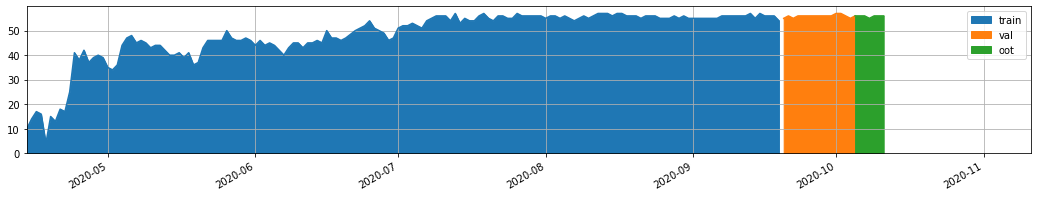

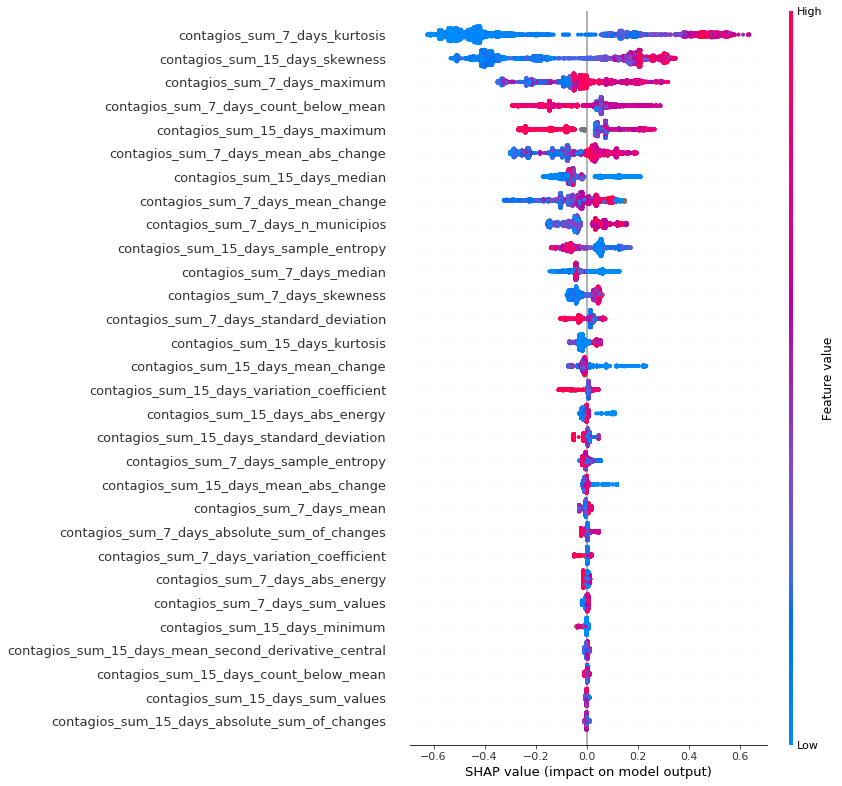

[23:58:52] WARNING: /workspace/src/learner.cc:480: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.998629  0.338183  0.505261   6461.0  2188.0  0.906306
1             0.261868  0.998026  0.414878   1520.0  5793.0  0.906306
avg / total   0.858311  0.463852  0.488047   7981.0  7981.0  0.906306, 'val':              precision    recall  f1-score  support   pred      AUC
0             1.000000  0.508731  0.674383    859.0  437.0  0.87638
1             0.080610  1.000000  0.149194     37.0  459.0  0.87638
avg / total   0.962034  0.529018  0.652695    896.0  896.0  0.87638, 'oot':              precision    recall  f1-score  support   pred       AUC
0           

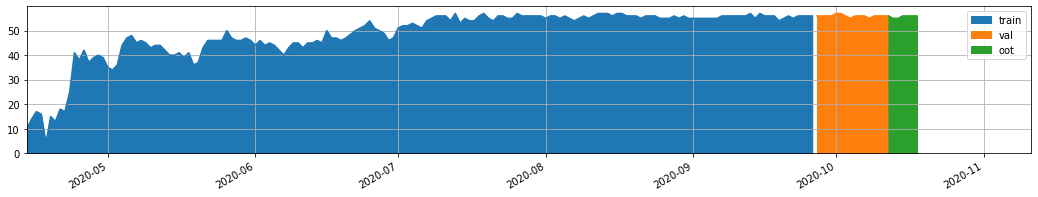

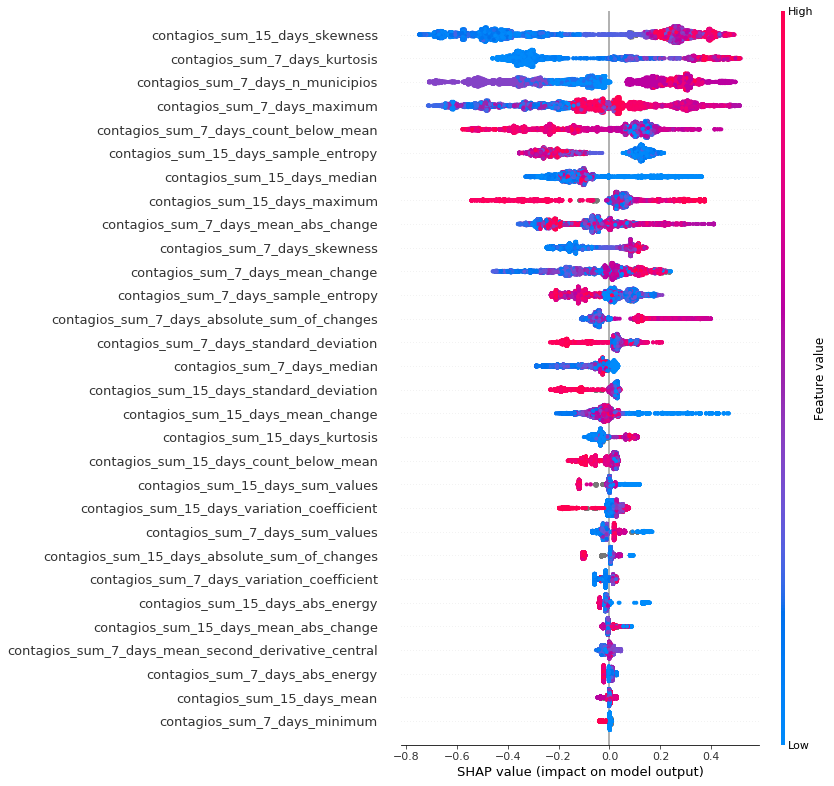

[23:59:01] WARNING: /workspace/src/learner.cc:480: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.991114  0.493147  0.658597   6785.0  3376.0  0.874172
1             0.304269  0.980443  0.464413   1534.0  4943.0  0.874172
avg / total   0.864461  0.583003  0.622790   8319.0  8319.0  0.874172, 'val':              precision    recall  f1-score  support   pred       AUC
0             0.961290  0.665922  0.786799    895.0  620.0  0.698788
1             0.088415  0.547170  0.152231     53.0  328.0  0.698788
avg / total   0.912490  0.659283  0.751322    948.0  948.0  0.698788, 'oot':              precision    recall  f1-score  support   pred       AUC
0       

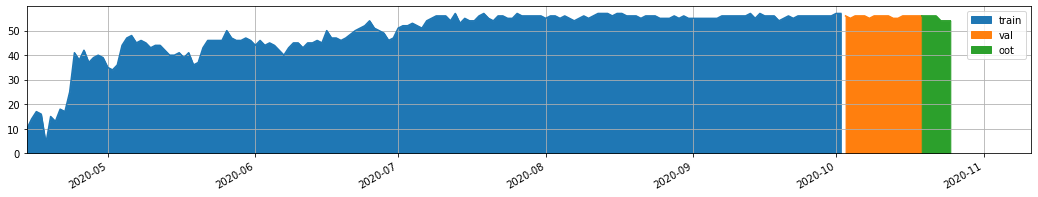

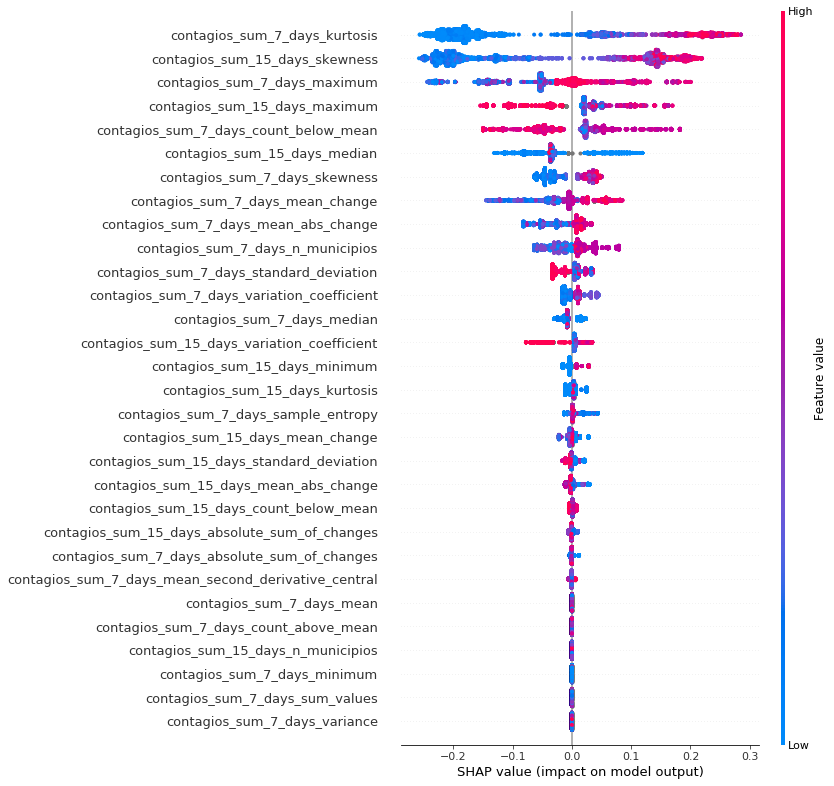

[23:59:06] WARNING: /workspace/src/learner.cc:480: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.997318  0.418366  0.589459   7111.0  2983.0  0.886587
1             0.270547  0.994812  0.425402   1542.0  5670.0  0.886587
avg / total   0.867804  0.521091  0.560223   8653.0  8653.0  0.886587, 'val':              precision    recall  f1-score  support    pred       AUC
0             0.967168  0.765980  0.854897    923.0   731.0  0.789471
1             0.197026  0.688312  0.306358     77.0   269.0  0.789471
avg / total   0.907867  0.760000  0.812660   1000.0  1000.0  0.789471, 'oot':              precision    recall  f1-score  support   pred       AUC
0   

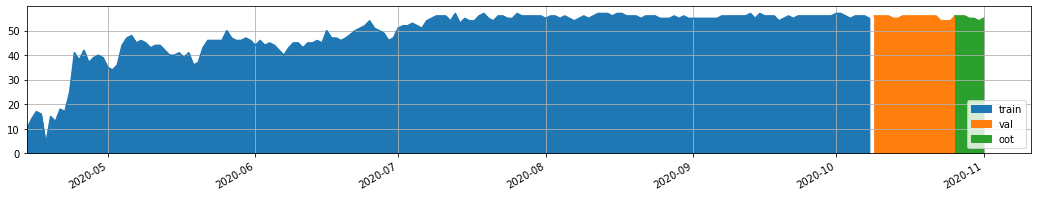

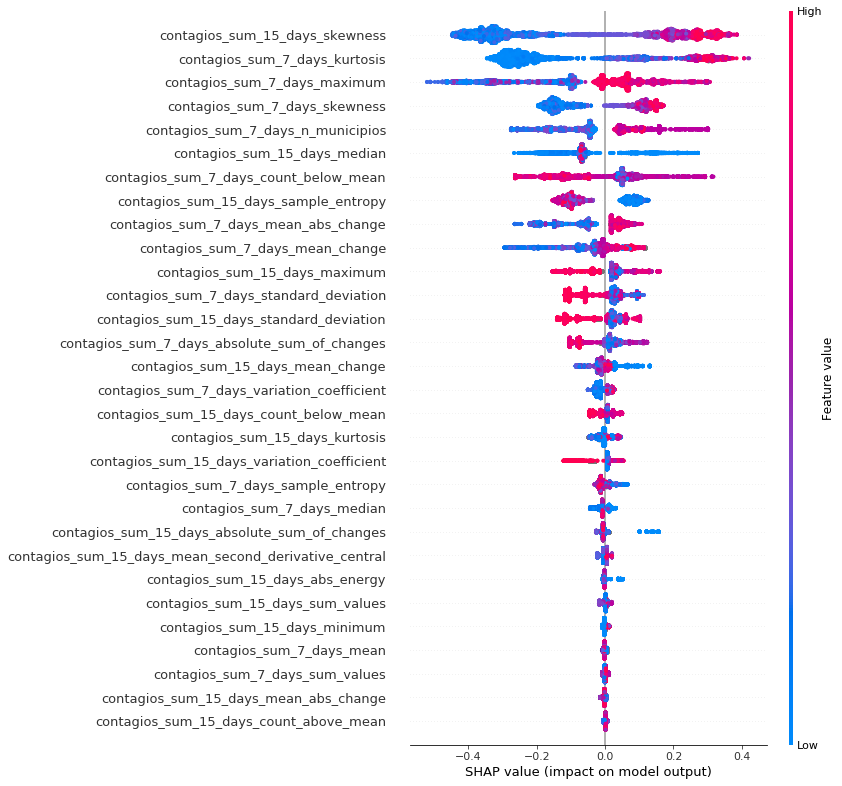

[23:59:11] WARNING: /workspace/src/learner.cc:480: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.993367  0.524515  0.686530   7424.0  3920.0  0.878891
1             0.303335  0.983365  0.463650   1563.0  5067.0  0.878891
avg / total   0.873358  0.604317  0.647767   8987.0  8987.0  0.878891, 'val':              precision    recall  f1-score  support    pred       AUC
0             0.952503  0.761807  0.846549    974.0   779.0  0.769234
1             0.147059  0.519481  0.229226     77.0   272.0  0.769234
avg / total   0.893493  0.744053  0.801322   1051.0  1051.0  0.769234, 'oot':              precision    recall  f1-score  support   pred       AUC
0   

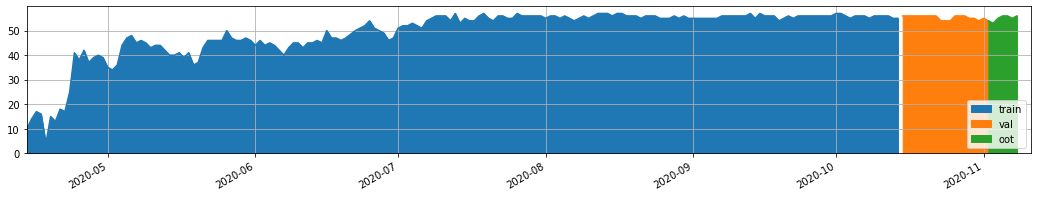

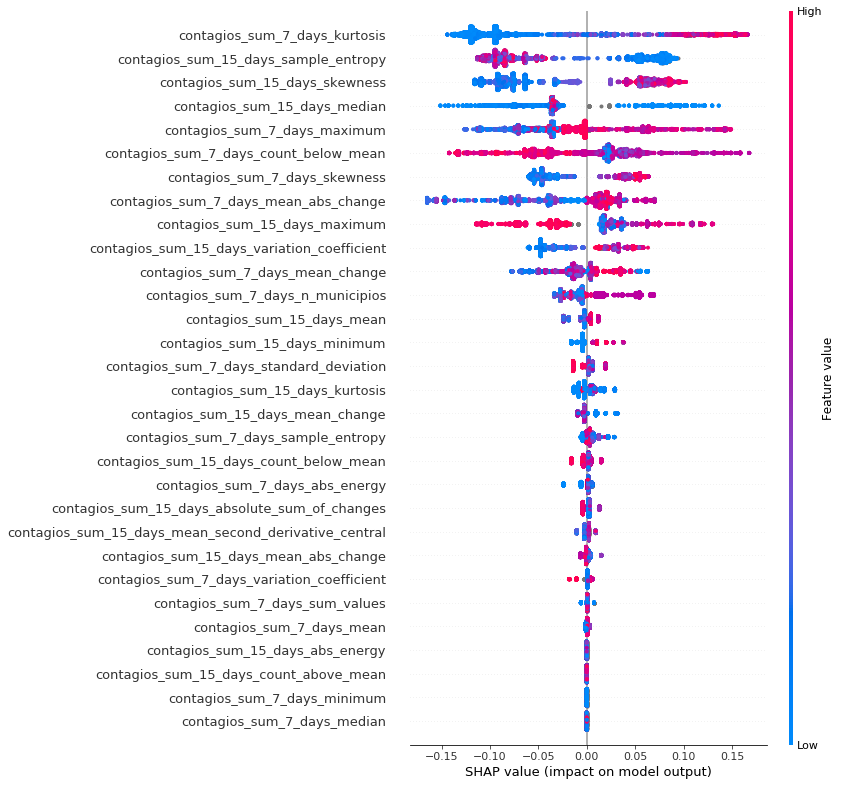

[23:59:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.991872  0.533290  0.693639   7780.0  4183.0  0.891754
1             0.301193  0.978737  0.460633   1599.0  5196.0  0.891754
avg / total   0.874120  0.609233  0.653914   9379.0  9379.0  0.891754, 'val':              precision    recall  f1-score  support    pred       AUC
0             0.990157  0.509109  0.672460    988.0   508.0  0.864408
1             0.096834  0.912281  0.175084     57.0   537.0  0.864408
avg / total   0.941431  0.531100  0.645330   1045.0  1045.0  0.864408, 'oot':              precision    recall  f1-score  support   pred       AUC
0   

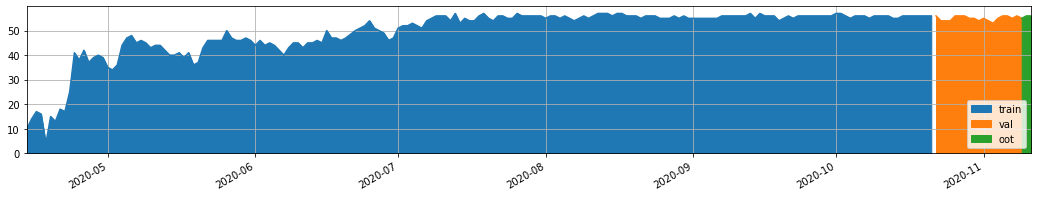

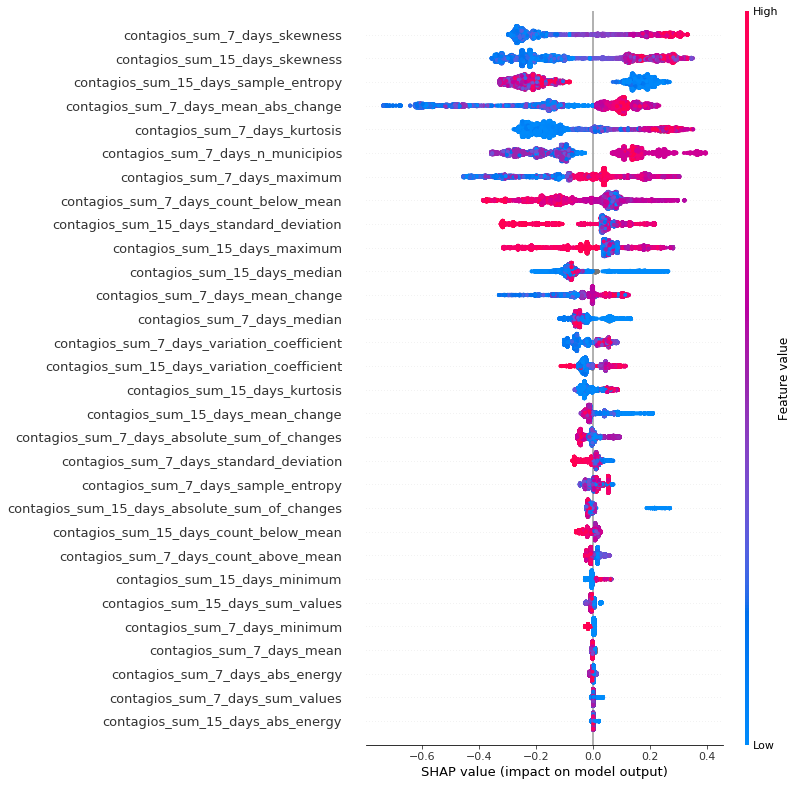

In [9]:
reports, feature_importance, dates = [], [], []
for date, oot in date_data.set_index('fecha').groupby(pd.Grouper(freq='7D')):
    dates.append(date)
    oot.reset_index(inplace=True)
    train = data_[data_['fecha'] <= date]

    oos_size = .1
    val_boundary = train['fecha'].quantile(1 - oos_size)

    val = train[train['fecha'] >= val_boundary]
    train = train[train['fecha'] < val_boundary]
    
    # Split data
    X_train = train.set_index(['fecha', 'nombre_hospital']).copy()
    X_train.drop(list(set(X_train.columns).intersection(forbiden)), axis=1, inplace=True)
    y_train = train.set_index(['fecha', 'nombre_hospital'])[target]

    X_val = val.set_index(['fecha', 'nombre_hospital']).copy()
    X_val.drop(list(set(X_val.columns).intersection(forbiden)), axis=1, inplace=True)
    y_val = val.set_index(['fecha', 'nombre_hospital'])[target]

    X_oot = oot.set_index(['fecha', 'nombre_hospital']).copy()
    X_oot.drop(list(set(X_oot.columns).intersection(forbiden)), axis=1, inplace=True)
    y_oot = oot.set_index(['fecha', 'nombre_hospital'])[target]
    
#     plot_folds(X_train, X_val, X_oot)
    
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    model = xgb.XGBClassifier(
        subsample=.7,
        col_subsample=.5,
        max_depth=4,
        learning_rate=.05,
        min_child_weight=100,
        scale_pos_weight=scale_pos_weight
    )

    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric=['logloss', 'auc'],
        early_stopping_rounds=10,
        verbose=False)

    y_train_score = model.predict_proba(X_train)
    y_val_score = model.predict_proba(X_val)
    y_oot_score = model.predict_proba(X_oot)

    # Evaluate
    score_th = pd.Series(y_oot_score[:, 1]).quantile(.5)
    report_train = eval_utils.classification_report(
        y_true=y_train, 
        y_score=y_train_score, 
        y_pred=(y_train_score[:, 1] > score_th).astype(int))

    report_val = eval_utils.classification_report(
        y_true=y_val, 
        y_score=y_val_score, 
        y_pred=(y_val_score[:, 1] > score_th).astype(int))

    report_oot = eval_utils.classification_report(
        y_true=y_oot, 
        y_score=y_oot_score, 
        y_pred=(y_oot_score[:, 1] > score_th).astype(int))
    
    local_reports = {
        'train': report_train,
        'val': report_val,
        'oot': report_oot,
        'date': date
    }
    
    print(local_reports)
    reports.append(local_reports)
    
    plot_folds(X_train, X_val, X_oot)
    
    fig, ax = plt.subplots(1, 1)
    explainer = shap.TreeExplainer(model)
    
    shaps_values = pd.DataFrame(
        explainer.shap_values(X_train),
        columns=X_train.columns)

    shap.summary_plot(
        shaps_values.values, 
        X_train,
        max_display=30)
    
    feature_importance.append(shaps_values.abs().sum(axis=0).sort_values())
    
feature_importance = pd.DataFrame(
    feature_importance,
    index=dates)

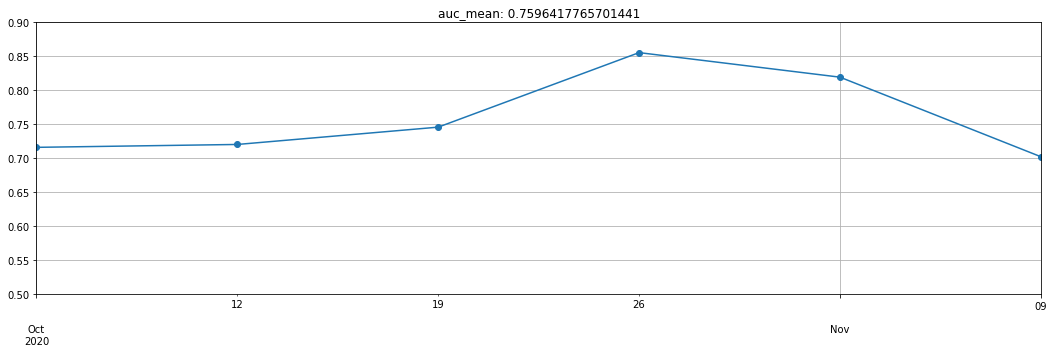

In [10]:
auc = pd.Series([r['oot']['AUC']['avg / total'] for r in reports])
auc.index = [r['date'] for r in reports]

auc_mean = auc.mean()

auc.plot(
    marker='o',
    grid=True,
    figsize=(18, 5),
    ylim=(.5, .9),
    title='auc_mean: %s' % auc_mean)

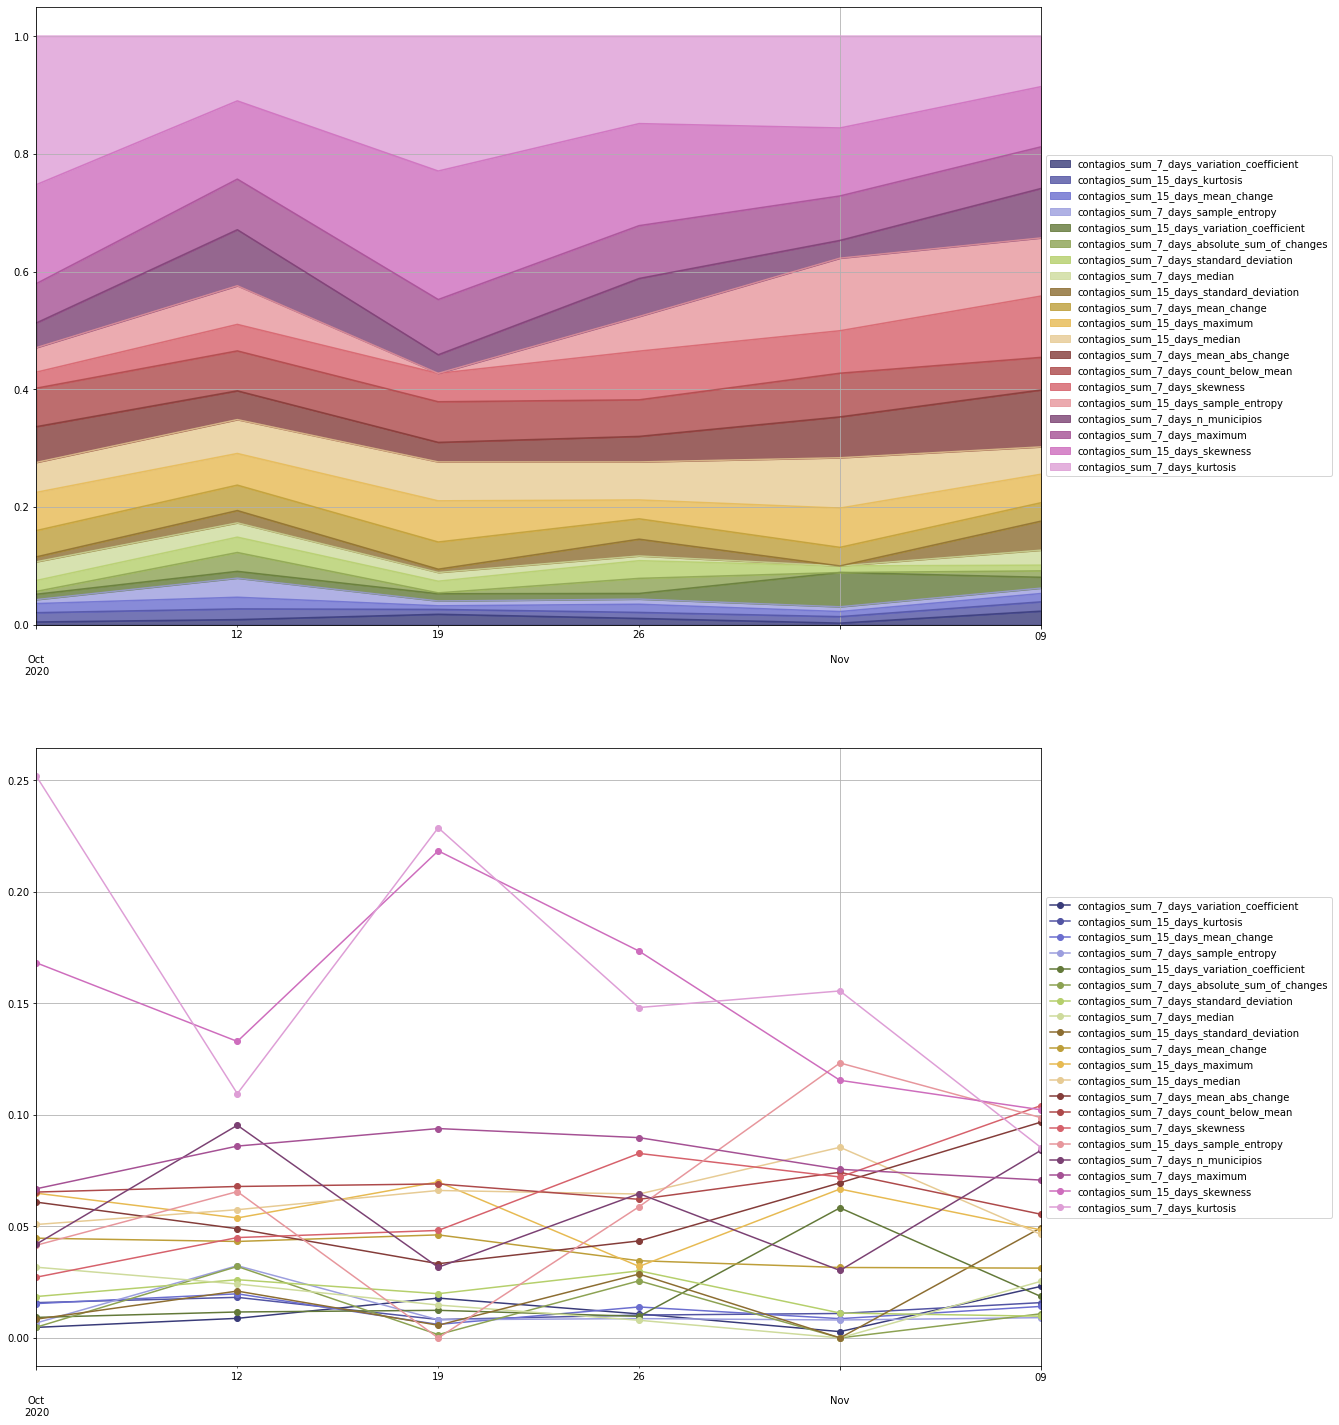

In [12]:
data_plot = feature_importance[feature_importance.sum().sort_values().iloc[-20:].index]
data_plot = (data_plot.T / data_plot.sum(axis=1)).T

fig, ax = plt.subplots(2, 1, figsize=(18, 25))
data_plot.plot(
    kind='area',
    stacked=True,
    ax=ax[0],
    grid=True,
    alpha=.8,
    cmap='tab20b')

data_plot.plot(
    marker='o', 
    ax=ax[1],
    cmap='tab20b',
    legend=False,
    grid=True)

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [11]:
data_plot.columns

Index(['contagios_sum_7_days_absolute_sum_of_changes',
       'contagios_sum_7_days_variation_coefficient',
       'contagios_sum_15_days_count_below_mean', 'contagios_sum_7_days_median',
       'contagios_sum_15_days_mean_change',
       'contagios_sum_7_days_sample_entropy', 'contagios_sum_15_days_kurtosis',
       'contagios_sum_15_days_standard_deviation',
       'contagios_sum_15_days_variation_coefficient',
       'contagios_sum_7_days_standard_deviation',
       'contagios_sum_7_days_mean_change', 'contagios_sum_7_days_n_municipios',
       'contagios_sum_15_days_sample_entropy',
       'contagios_sum_7_days_mean_abs_change', 'contagios_sum_15_days_median',
       'contagios_sum_7_days_skewness',
       'contagios_sum_7_days_count_below_mean', 'contagios_sum_7_days_maximum',
       'contagios_sum_15_days_skewness', 'contagios_sum_7_days_kurtosis'],
      dtype='object')